# **Named Entity Recognition with the Kaggle NER Dataset**

This notebook demonstrates the implementation of a Token Classification model using an LSTM network for Named Entity Recognition (NER) task, leveraging the [Kaggle NER Dataset](https://www.kaggle.com/datasets/namanj27/ner-dataset).

### **Imports**

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.core.display import HTML
from google.colab import drive

### **Parameters**

In [2]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
epochs = 10
batch_size = 64
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED= 123
vocab_size = None #Include the entire vocabulary, encompassing the padding and unknown tokens
embedding_dim = 128

### **Load and Preprocess the Dataset**

The dataset was downloaded from the provided link on the official Kaggle website and then uploaded to my personal Google Drive. It comprises 4 columns: ``# Sentence``, ``Word``, ``POS``, and ``Tag``. For the NER task, we will utilize all columns except ``POS``, as it is used for another token classification task, namely Part-of-Speech (PoS) Tagging.

**NER Label Descriptions:**

- **O: Outside**. Indicates that the word does not belong to any named entity.
- **B-geo: Beginning of a geographic location**. Indicates that the word is the beginning of a geographic entity (e.g., a country, city, or place).
- **I-geo: Inside of a geographic location**. Indicates that the word is part of a geographic entity but is not the beginning.
- **B-tim: Beginning of a time expression**. Indicates that the word is the beginning of a temporal expression (e.g., a date or time).
- **I-tim: Inside of a time expression**. Indicates that the word is part of a temporal expression but is not the beginning.
- **B-org: Beginning of an organization**. Indicates that the word is the beginning of an organizational entity (e.g., a company or institution).
- **I-org: Inside of an organization.** Indicates that the word is part of an organizational entity but is not the beginning.
- **B-per: Beginning of a person**. Indicates that the word is the beginning of an entity referring to a person.
- **I-per: Inside of a person**. Indicates that the word is part of an entity referring to a person but is not the beginning.
- **B-gpe: Beginning of a geopolitical entity**. Indicates that the word is the beginning of a geopolitical entity (e.g., a country, state, or city).
- **I-gpe: Inside of a geopolitical entity**. Indicates that the word is part of a geopolitical entity but is not the beginning.
- **B-art: Beginning of an artifact**. Indicates that the word is the beginning of an entity referring to an artifact (e.g., a work of art, a book).
- **I-art: Inside of an artifact**. Indicates that the word is part of an entity referring to an artifact but is not the beginning.
- **B-eve: Beginning of an event**. Indicates that the word is the beginning of an entity referring to an event (e.g., a conference, a match).
- **I-eve: Inside of an event**. Indicates that the word is part of an entity referring to an event but is not the beginning.
- **B-nat: Beginning of a natural phenomenon**. Indicates that the word is the beginning of an entity referring to a natural phenomenon (e.g., a hurricane, an earthquake).
- **I-nat: Inside of a natural phenomenon**. Indicates that the word is part of an entity referring to a natural phenomenon but is not the beginning.

In [4]:
# Unzip the dataset
!unzip -q /content/drive/MyDrive/Datasets/ner_datasetreference.csv.zip

In [102]:
# Load the dataset
df = pd.read_csv("/content/ner_datasetreference.csv", encoding="latin1")

# Completing missing values in the 'Sentence #' column using previous values
df["Sentence #"].fillna(method="ffill", inplace=True)

# Remove sentences containing at least one null Word
sentences_nan = df[df.Word.isna()]["Sentence #"].unique()
df = df[~df["Sentence #"].isin(sentences_nan)]

# Variable to view the count of values for each 'Tag'
tag_counts = df.Tag.value_counts()

# Grouping words and tags by sentence
df = df.groupby("Sentence #")[["Word", "Tag"]].agg(lambda x: " ".join(x))
df

,Word,Tag
Sentence #,,
Sentence: 1,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
Sentence: 10,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
Sentence: 100,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
Sentence: 1000,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
Sentence: 10000,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...
...,...,...
Sentence: 9995,Opposition leader Mir Hossein Mousavi has said...,O O O B-per I-per O O O O O O O O O O O O O O ...
Sentence: 9996,"On Thursday , Iranian state media published a ...",O B-tim O B-gpe O O O O O O O O B-org I-org O ...
Sentence: 9997,"Following Iran 's disputed June 12 elections ,...",O B-geo O O B-tim I-tim O O O O O O O O O O O ...


In [103]:
tag_counts

Tag
O        887788
B-geo     37643
B-tim     20331
B-org     20142
I-per     17251
B-per     16990
I-org     16783
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

It can be observed that the dataset is unbalanced regarding the "Tag" values, with the most affected ones ranging from ``B-art`` to ``I-nat``.

In [6]:
# There are no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47949 entries, Sentence: 1 to Sentence: 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    47949 non-null  object
 1   Tag     47949 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


**Splitting the dataframe into training (70%), validation (15%) y testing (15%) sets**

In [7]:
df_train, df_val_test = train_test_split(df, test_size=0.3, random_state=SEED)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=SEED)

del df, df_val_test #Remove to free memory

len(df_train), len(df_val), len(df_test)

(33564, 7192, 7193)

**Creation of Sentence and Label Encoders**

To tokenize the sentences, the `TextVectorization` layer is employed, which encodes the text into indices by frequency order, considering up to `vocab_size`. The index tensors are padded with zeros to reach the length of the longest sequence in the batch unless a fixed value for `output_sequence_length` is specified. In this case, the `standardize` argument is set to None since punctuation marks should not be removed or sentences converted to lowercase, as this could affect the NER task. A capital letter within a sentence may indicate an entity, and all words are separated by spaces, including punctuation marks.

For tokenizing the labels, the `tf.keras.preprocessing.text.Tokenizer` function is used. Similar to sentences, the labels are not converted to lowercase, and punctuation marks are not removed since the labels are already predefined. Additionally, padding is added up to the longest sequence using the `tf.keras.utils.pad_sequences` function to match the tokenized sentences.

In [8]:
tf.random.set_seed(SEED)

encoder_x = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize=None)
encoder_x.adapt(df_train.Word.values)
vocab_x = np.array(encoder_x.get_vocabulary())

print(encoder_x.vocabulary_size())
vocab_x[:10]

30180


array(['', '[UNK]', 'the', '.', ',', 'of', 'in', 'to', 'a', 'and'],
      dtype='<U64')

In [9]:
encoder_y = tf.keras.preprocessing.text.Tokenizer(lower=False, filters="")
encoder_y.fit_on_texts(df_train.Tag.values)

vocab_y = encoder_y.word_index
vocab_y_inv = encoder_y.index_word
print(len(vocab_y))
vocab_y

17


{'O': 1,
 'B-geo': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-per': 5,
 'B-per': 6,
 'I-org': 7,
 'B-gpe': 8,
 'I-geo': 9,
 'I-tim': 10,
 'B-art': 11,
 'B-eve': 12,
 'I-art': 13,
 'I-eve': 14,
 'I-gpe': 15,
 'B-nat': 16,
 'I-nat': 17}

In [10]:
def generate_dataset(df, shuffle=False):
  sentences_ids = encoder_x(df.Word.values)
  labels_ids = encoder_y.texts_to_sequences(df.Tag.values)
  labels_ids = tf.keras.utils.pad_sequences(labels_ids, padding="post")

  dataset = tf.data.Dataset.from_tensor_slices((sentences_ids, labels_ids))
  if shuffle:
    dataset = dataset.shuffle(buffer_size, seed=SEED)
  dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

  return dataset

In [11]:
train_dataset = generate_dataset(df_train, shuffle=True)
val_dataset = generate_dataset(df_val)
test_dataset = generate_dataset(df_test)

del df_train, df_val

In [12]:
# Visualizing a tokenized batch
for texts, labels in train_dataset.take(1):
  print(texts, "\n")
  print(labels)

tf.Tensor(
[[   10    68   359 ...     0     0     0]
 [   10    52    14 ...     0     0     0]
 [   10 16266   333 ...     0     0     0]
 ...
 [   48  1384  1950 ...     0     0     0]
 [  394   616     6 ...     0     0     0]
 [  705     6   246 ...     0     0     0]], shape=(64, 104), dtype=int64) 

tf.Tensor(
[[ 1  1  1 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]
 [ 1  4  1 ...  0  0  0]
 ...
 [ 1  2  9 ...  0  0  0]
 [ 3 10  1 ...  0  0  0]
 [ 1  1  2 ...  0  0  0]], shape=(64, 104), dtype=int32)


In [15]:
# Viewing the results of tokenization

id = 2

print(texts[id].numpy())
decoded_texts = " ".join(vocab_x[texts[id]])
print(decoded_texts, "\n")

print(labels[id].numpy())
decoded_labels = encoder_y.sequences_to_texts([labels[id].numpy()])[0]
print(decoded_labels)

[   10 16266   333  2753     2 14435     5     8 21401  1993    16    64
  4086  2959  2326 28960  1170 14710     4   140  6112     9 26919 14996
     4     2  5249    55  4616     2  6694     3     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
The Filmyard deal marks the culmination of a drawn-out sale that had attracted various Los Angeles-based rival bidders , including Bob and Harvey Weinstein , the brothers who founded the studio .                                                                         

[1 4 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 6 1 6 5 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 

### **Build the Model**

In [15]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=encoder_x.vocabulary_size(),
        output_dim=embedding_dim,
        mask_zero=True, #Indicates that the value 0 is a padding value that should be masked
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Dense(len(vocab_y)+1, activation="softmax") #+1 for the padding token (0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3863040   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, None, 18)          4626      
                                                                 
Total params: 4130834 (15.76 MB)
Trainable params: 4130834 (15.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


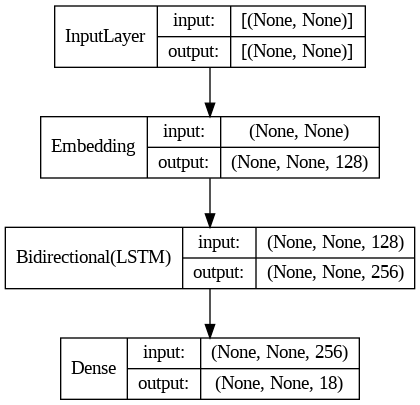

In [16]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

### **Compile and Train the Model**

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=0), #Ignore label 0 when calculating loss and accuracy
    metrics=["accuracy"]
)

# Callback to stop training early if validation accuracy does not improve for 2 epochs.
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

In [ ]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/10
525/525 [==============================] - 43s 56ms/step - loss: 0.1898 - accuracy: 0.9495 - val_loss: 0.1062 - val_accuracy: 0.9681
Epoch 2/10
525/525 [==============================] - 15s 29ms/step - loss: 0.0787 - accuracy: 0.9750 - val_loss: 0.1070 - val_accuracy: 0.9685
Epoch 3/10
525/525 [==============================] - 13s 25ms/step - loss: 0.0613 - accuracy: 0.9799 - val_loss: 0.1129 - val_accuracy: 0.9672
Epoch 4/10
525/525 [==============================] - 9s 17ms/step - loss: 0.0518 - accuracy: 0.9826 - val_loss: 0.1193 - val_accuracy: 0.9677


**Save model**

In [ ]:
model.save("/content/drive/MyDrive/models/NER_LSTM_Kaggle.keras")

### **Dataset Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.05866289511322975, 0.980696976184845]
[0.10702528059482574, 0.9685366153717041]
[0.10966098308563232, 0.9671399593353271]


**Consolidating the accuracy of the testing set**

In [32]:
labels_test = test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_test = np.array(list(labels_test))

labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)
mask = (labels_test != 0).astype(np.float32)
matches_true_pred = (labels_test == labels_test_pred).astype(np.float32)
matches_true_pred *= mask

masked_accuracy = np.sum(matches_true_pred) / np.sum(mask)
masked_accuracy

0.96713996

After just 2 epochs, the training set achieves an accuracy of 98.1%, while the validation set accuracy is 96.9%, and the test set accuracy is 96.7%. If we were to continue training for more epochs, the training set accuracy would increase to 100%, but that of the validation and test sets would decrease. Although the model is quite good, it shows signs of slight overfitting, which we managed to mitigate effectively thanks to the callback, which stops training when the validation accuracy does not improve for 2 consecutive epochs. To achieve even better results, it would be advisable to expand the training dataset and/or use more robust architectures, such as Transformers networks. However, the model performs well in recognizing named entities, as seen later on.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = metric.capitalize()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()
plot_metrics(metric="accuracy")

**Images for GitHub**

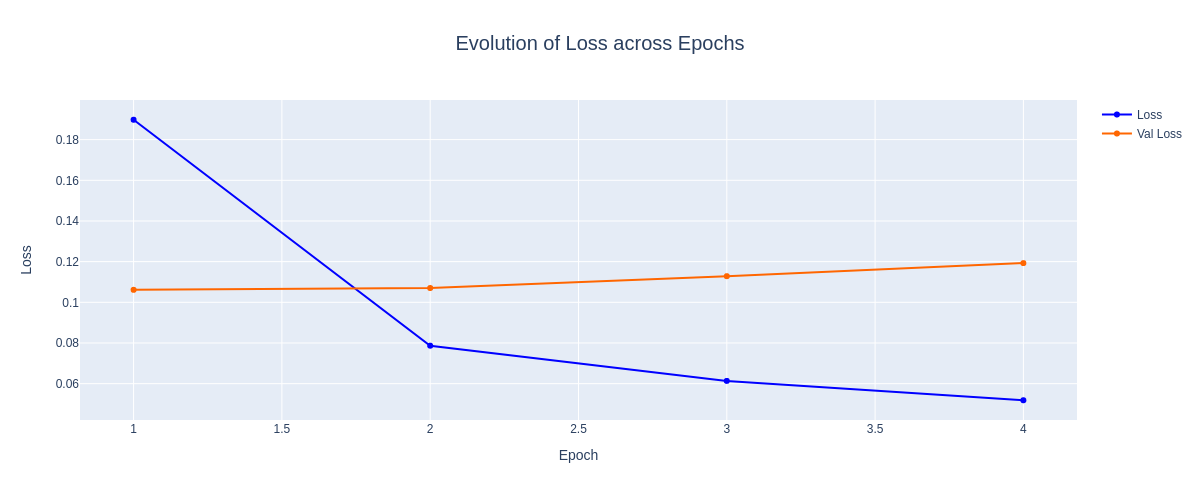

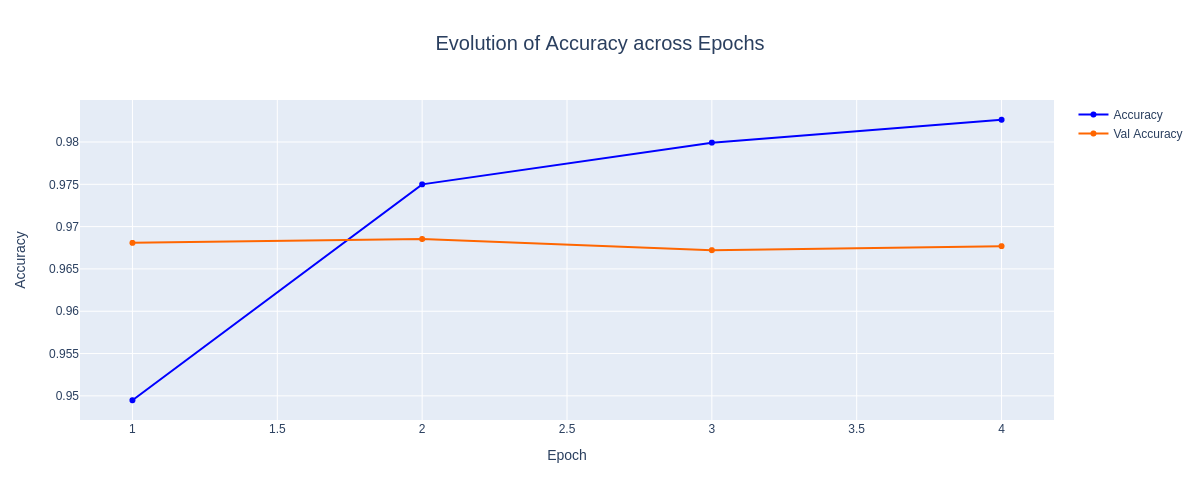

In [ ]:
plot_metrics(renderer="png")
plot_metrics(renderer="png", metric="accuracy")

### **Predictions with the trained model**

In [10]:
# Loading the trained model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("/content/drive/MyDrive/models/NER_LSTM_Kaggle.keras")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3863040   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, None, 18)          4626      
                                                                 
Total params: 4130834 (15.76 MB)
Trainable params: 4130834 (15.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Function to predict named entities

def predict_label(sentences, labels=None, random=True, indice=0):
  indice = np.random.choice(len(sentences)) if random else indice

  sentence = sentences[indice]
  sentence_ids = encoder_x([sentence])

  label_ids_pred = model.predict(sentence_ids, verbose=0).squeeze()
  label_ids_pred = np.argmax(label_ids_pred, axis=-1)

  display(HTML(f"<b>Sentence:</b> {sentence}<br><br>"))
  html_content = """
  <table style="border-collapse: separate; border-spacing: 15px; text-align: center;">
    <tr>
      <th>Word</th>
      <th>Predicted Tag</th>
  """

  if labels is not None:
    label_colors = {"incorrect":"red", "correct":"green"}
    label = labels[indice]
    label_ids = encoder_y.texts_to_sequences([label])[0]
    html_content += "<th>True Tag</th>"
  html_content += "</tr>"

  for i in range(len(label_ids_pred)):
    cond = vocab_y_inv[label_ids[i]] if labels is not None else vocab_y_inv[label_ids_pred[i]]
    if cond != "O":

      html_content += f"""
        <tr>
          <td>{vocab_x[sentence_ids[0][i]]}</td>
          <td>{vocab_y_inv[label_ids_pred[i]]}</td>
        """

      if labels is not None:
        result = "correct" if label_ids[i] == label_ids_pred[i] else "incorrect"

        html_content += f"""
          <td>{vocab_y_inv[label_ids[i]]}</td>
          <td><b><span style="color:{label_colors[result]}">{result}</span></b></td>
        """
      html_content += "</tr>"

  html_content += "</table>"
  display(HTML(html_content))

#### **Test Dataset**

In [12]:
sentences, labels = df_test.Word.values, df_test.Tag.values

In [40]:
predict_label(sentences, labels, random=False)

In [59]:
predict_label(sentences, labels)

In [158]:
predict_label(sentences, labels, random=False, indice=109)

In [53]:
predict_label(sentences, labels)

Word,Predicted Tag,True Tag


In [210]:
predict_label(sentences, labels)

In [ ]:
predict_label(sentences, labels)

In [115]:
predict_label(sentences, labels, random=False, indice=2093)

#### **Other Sentences**

In [225]:
sentence = ["""
George Smith , the White House director of trade and manufacturing policy of U.S , said in an interview on Sunday
morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall ,
though he said it wouldn 't necessarily come
"""]

predict_label(sentence)

Word,Predicted Tag
George,B-per
Smith,I-per
White,B-org
House,I-org
U.S,B-org
Sunday,B-tim
morning,I-tim
White,B-org
House,I-org


In [224]:
sentence = ["""
In Tokyo , Japan , the United Nations announced on Monday that they will hold a global climate summit in December .
The event , which will include representatives from over 150 countries , aims to address the urgent issues of climate change
and global warming . UN Secretary-General Antonio Guterres emphasized the need for immediate action to protect the planet .
"""]

predict_label(sentence)


Word,Predicted Tag
Tokyo,B-geo
Japan,B-geo
United,B-org
Nations,I-org
Monday,B-tim
December,B-tim
UN,B-org
Secretary-General,I-org
Antonio,B-per
Guterres,I-per


**Conclusion:** It can be observed that the model correctly detects named entities in the sentences of the test set, as well as in others that do not belong to the Kaggle NER Dataset, even if they are long or complex. It is also noticeable that the model shows some shortcomings in tags with lower frequency in the sentences, such as ``B-art`` and ``I-art``, where words could be confused with another tag if the context is not deeply analyzed. Therefore, although the model is excellent, improving its performance would require increasing the training dataset with sentences containing the minority tags to balance them with the other tags. Additionally, as mentioned earlier, it would be advisable to consider the use of Transformers networks to effectively capture the complex contexts of the sentences.